In [1]:
import json
from pathlib import Path

import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer
from datasets import Dataset

from tqdm.auto import tqdm

/mnt/shared_home/vlialin/miniconda3/envs/clinicallm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
dataset = Dataset.from_json("../data/faiss/faiss_index_14-32-52/merged.jsonl")
dataset

Found cached dataset json (/mnt/shared_home/hf_cache/datasets_cache/json/default-9da4b8cdf0a9bef3/0.0.0)


Dataset({
    features: ['meta_data', 'pmid', 'text'],
    num_rows: 787370
})

Loading cached processed dataset at /mnt/shared_home/hf_cache/datasets_cache/json/default-9da4b8cdf0a9bef3/0.0.0/cache-c93faa86df44bbca.arrow


95 percentile: 134.0
99 percentile: 157.0
Number of docs shorter than 128: 9245
Percentage of docs shorter than 128: 0.9245


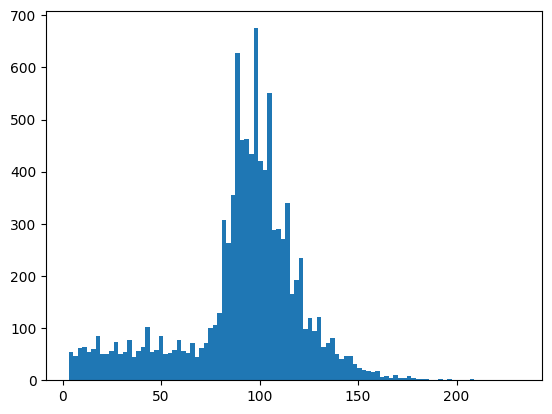

In [3]:
# make length histogram
dataset_w_lengths = dataset.select(range(10000)).map(lambda x: {"length": len(tokenizer(x["text"])["input_ids"])})
lengths = np.array(dataset_w_lengths["length"])

# print 95, and 99 percentiles
print(f"95 percentile: {np.percentile(lengths, 95)}")
print(f"99 percentile: {np.percentile(lengths, 99)}")

from matplotlib import pyplot as plt
plt.hist(lengths, bins=100)

# how many docs are shorter than 128
print(f"Number of docs shorter than 128: {sum([1 for l in lengths if l < 128])}")
# percentage of docs shorter than 128
print(f"Percentage of docs shorter than 128: {sum([1 for l in lengths if l < 128]) / len(lengths)}")

In [4]:
model = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
model = model.to(device="cuda", dtype=torch.bfloat16)

In [5]:
# def embed_batched(batch):
#     torch_batch = tokenizer(batch["text"], return_tensors="pt", padding=True, truncation=True, max_length=128)
#     torch_batch = torch_batch.to(device="cuda")

#     last_hidden = model(**torch_batch).last_hidden_state.detach().to(device="cpu", dtype=torch.float32).numpy()
#     last_hidden_list = np.split(last_hidden, last_hidden.shape[0], axis=0)

#     batch["embeddings"] = last_hidden_list
#     return batch

# dataset = dataset.map(embed_batched, batched=True, batch_size=256)
# dataset

In [6]:
def tokenize_batch(batch):
    torch_batch = tokenizer(batch["text"], max_length=128, padding="max_length", truncation=True, return_tensors="pt")
    return {"input_ids": torch_batch["input_ids"].squeeze(0), "attention_mask": torch_batch["attention_mask"].squeeze(0)}

def embed_batch(batch):
    input_ids = [torch.LongTensor(i) for i in batch["input_ids"]]
    attention_mask = [torch.LongTensor(i) for i in batch["attention_mask"]]

    input_ids = torch.stack(input_ids).to(device="cuda")
    attention_mask = torch.stack(attention_mask).to(device="cuda")

    out = model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden = out.last_hidden_state.detach().to(device="cpu", dtype=torch.float32).numpy()
    last_hidden_list = np.split(last_hidden, last_hidden.shape[0], axis=0)
    return {"hidden_state": last_hidden_list}

In [7]:
dataset = dataset.map(tokenize_batch, batched=True, batch_size=256, num_proc=8)

In [ ]:
import torch.data

dataloader = torch.data.DataLoader(dataset, batch_size=256, num_workers=8)


In [8]:
dataset = dataset.map(embed_batch, batched=True, batch_size=256)

Parameter 'function'=<function embed_batch at 0x7f2a35a753f0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:   0%|          | 0/787370 [00:00<?, ? examples/s]

KeyboardInterrupt: 